In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from scipy import interpolate
from mpl_toolkits import mplot3d
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from mat4py import loadmat

from pylab import figure, show
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import truncnorm
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import LightSource
from scipy.stats import gaussian_kde



WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:

#====================================================
# Make plots beautiful
#====================================================

pts_per_inch = 72.27
# write "\the\textwidth" (or "\showthe\columnwidth" for a 2 collumn text)
text_width_in_pts = 300.0
# inside a figure environment in latex, the result will be on the
# dvi/pdf next to the figure. See url above.
text_width_in_inches = text_width_in_pts / pts_per_inch
# figure.png or figure.eps will be intentionally larger, because it is prettier
inverse_latex_scale = 2
fig_proportion = (3.0 / 3.0)
csize = inverse_latex_scale * fig_proportion * text_width_in_inches
# always 1.0 on the first argument
fig_size = (1.0 * csize, 0.85 * csize)
# find out the fontsize of your latex text, and put it here
text_size = inverse_latex_scale * 9
label_size = inverse_latex_scale * 10
tick_size = inverse_latex_scale * 8
# learn how to configure:
# http://matplotlib.sourceforge.net/users/customizing.html
params = {'backend': 'ps',
          'axes.labelsize': 16,
          'legend.fontsize': tick_size,
          'legend.handlelength': 2.5,
          'legend.borderaxespad': 0,
          'axes.labelsize': label_size,
          'xtick.labelsize': tick_size,
          'ytick.labelsize': tick_size,
          'font.family': 'serif',
          'font.size': text_size,
          'font.serif': ['Computer Modern Roman'],
          'ps.usedistiller': 'xpdf',
          'text.usetex': True,
          'figure.figsize': fig_size,
          # include here any neede package for latex
          'text.latex.preamble': [r'\usepackage{amsmath}'],
          }
plt.rcParams.update(params)
fig = plt.figure(1, figsize=fig_size)  # figsize accepts only inches.
fig.subplots_adjust(left=0.04, right=0.98, top=0.93, bottom=0.15,
                     hspace=0.05, wspace=0.02)

# =============================================================================
# Arrows
# =============================================================================
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


<Figure size 597.758x508.095 with 0 Axes>

In [5]:
#parameters

a, b, c, d, f= 10, 2.1, 0.75, .0045, 0.0005

K, T=1.38066*10**-23, 293


In [13]:
num_sims = 100  # Display 1000 runs

with pm.Model():

	points=pm.HalfNormal('mu', sd=.2)

	trace=pm.sample(num_sims)

    

/opt/anaconda3/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 24 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8820615816633915, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [14]:
#####################################



y_init=trace.mu # initial points

t_init = 0
t_end  =199
N      = 1990  # Compute 1990 grid points
dt     = float(t_end - t_init) / N

In [15]:
# importing data

data = np.genfromtxt('test.dat')

points=data[:,0:2]
inputs=data[:,4].reshape(-1,1)
psi=data[:,2].reshape(-1,1)

(7000, 1)


In [16]:
#scaling the control policy to the interval of [.5,4]

M=np.max(inputs)
m=np.min(inputs)
m_n=0
M_n=10.

u_tilde=((inputs-m)/(M-m))*(M_n-m_n)+m_n

u_tilde=np.clip(u_tilde, .5, 4)

In [17]:
grid_x, grid_t = np.mgrid[0:6:600j, 0:200:2000j]

grid_u = griddata(points, u_tilde, (grid_x, grid_t), method='nearest').reshape(600,2000)

grid_psi = griddata(points, psi, (grid_x, grid_t), method='nearest').reshape(600,2000)


# grid_u = griddata(points, inputs, (grid_x, grid_t), method='nearest').reshape(600,2000)
# grid_u = griddata(points, inputs, (grid_x, grid_t), method='linear').reshape(600,1000)
# grid_u = griddata(points, inputs, (grid_x, grid_t), method='cubic2').reshape(600,2000)

In [18]:
def u(y,t):
    return grid_u[np.int(y*100),np.int(t*10)]


def D2(y, t):
    D2=f+d*np.exp(-(y-b-c*u(y,t))*(y-b-c*u(y,t)))
    return D2

def D1(y,t):
    D1=(D2(y,t)-f)*(-2*(y-b-c*u(y,t)))-2*a*K*T*(y-b-c*u(y,t))*D2(y,t)/(K*T)
    return D1

def dW(delta_t):
    """Sample a random number at each call."""
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))

<ipython-input-29-851bbf3c8ca2>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  delta=np.int(np.floor(40/dt))
<ipython-input-18-aca3bb68a0de>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more d

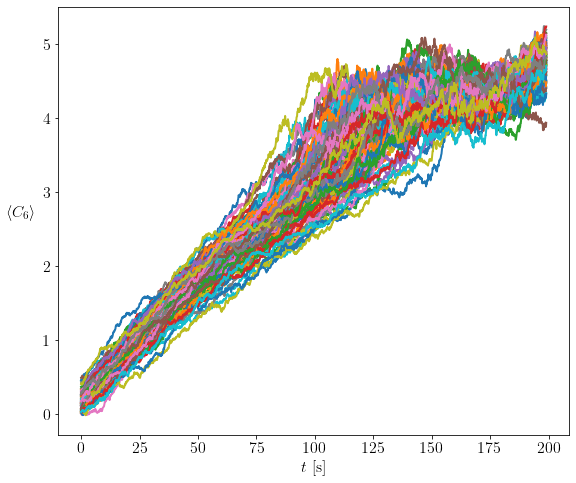

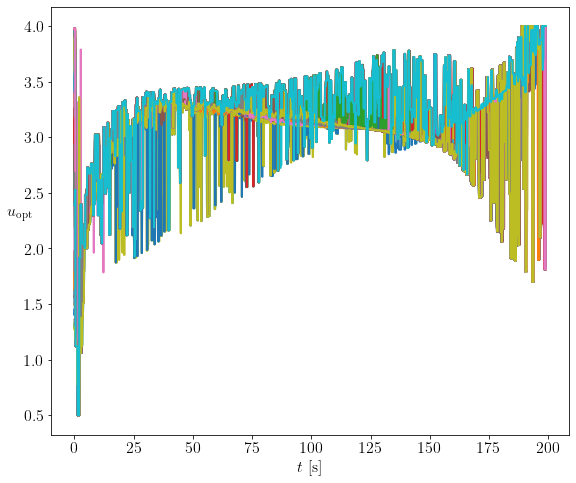

In [29]:
## closed-loop trajectories

ts = np.arange(t_init, t_end + dt, dt)
delta=np.int(np.floor(40/dt))
ys = np.zeros(N + 1)
yy=np.zeros((num_sims,N+1))
uu=np.zeros((num_sims,N+1))

end_points = np.zeros(num_sims)
points_0 = np.zeros(num_sims)
points_02 = np.zeros(num_sims)
points_04 = np.zeros(num_sims)
points_06 = np.zeros(num_sims)
points_08 = np.zeros(num_sims)
u_opt = np.zeros(N +1)





for _ in range(num_sims):
    ys[0] = y_init[_]
    for i in range(1, ts.size):
        t = t_init + (i - 1) * dt
        y = ys[i - 1]
        ys[i] = y + D1(y, t) * dt + np.sqrt(2*D2(y, t))* dW(dt)
        u_opt[i-1]=u(y,t)
        u_opt[-1]=u_opt[i-1]
    yy[_,:]=ys
    uu[_,:]=u_opt
    points_0[_]=ys[0]
    points_02[_]=ys[delta]
    points_04[_]=ys[2*delta]
    points_06[_]=ys[3*delta]
    points_08[_]=ys[4*delta]
    end_points[_]=ys[-1]

    
fig1, ax1 = plt.subplots(1,1)
for _ in range(num_sims):

    ax1.plot(ts, yy[_,:], linewidth=2)
ax1.set_xlabel(r'$t$ [s]', fontsize=16)
ax1.set_ylabel(r"$\langle C_{6} \rangle$ ", fontsize=16,rotation='horizontal')
ax1.yaxis.set_label_coords(-0.07, 0.5)
plt.tight_layout()
plt.savefig('OptimalClosed-loopStateTrajectories.png', dpi=300)

fig, ax = plt.subplots(1,1)
for _ in range(num_sims):

    ax.plot(ts, uu[_,:], linewidth=2)
# ax.plot(ts, u_opt, linewidth=2)
ax.set_xlabel(r'$t$ [s]', fontsize=16)
ax.set_ylabel(r"$ u_{\rm{opt}} $ ", fontsize=16,rotation='horizontal')
ax.yaxis.set_label_coords(-0.06, 0.5)
plt.tight_layout()
plt.savefig('OptimalControlTrajectories.png', dpi=300)





In [20]:
np.savetxt('points.out', (points_0,points_02,points_04,points_06,points_08,end_points))  

In [21]:
points = np.genfromtxt('points.out')
print(points.shape)

points_0=points[0,:]
points_02=points[1,:]
points_04=points[2,:]
points_06=points[3,:]
points_08=points[4,:]
end_points=points[5,:]

(6, 100)


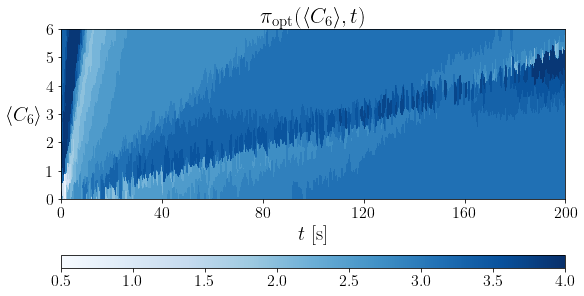

In [22]:
##optimal control policy
X=grid_x
Y=grid_t
Z=grid_u
fig, ax = plt.subplots(1, 1, constrained_layout=True) 
pcm=ax.imshow(Z,extent=[0, 200, 0, 6],cmap='Blues', alpha=1)
plt.close()
fig, ax = plt.subplots(1, 1, constrained_layout=True) 
contours=ax.contourf(Y, X, Z, 20, cmap='Blues')
fig.colorbar(pcm, shrink=.9999, location='bottom')

plt.yticks(( 0, 1, 2,3,4,5,6))
plt.xticks((0, 40,80,120,160,200))
ax.set_title(r"$\pi_{\rm{opt}}(\langle C_{6} \rangle,t)$") 
ax.set_ylabel(r"$\langle C_{6} \rangle$", rotation="horizontal")
ax.set_xlabel(r" $t$ [s]", rotation="horizontal")
ax.yaxis.set_label_coords(-.07,.43)
fig.set_size_inches(8,4)
plt.savefig('OptimalPolicy.png', dpi=300)


array([[-0.37128901, -0.37128901, -0.37128901, ...,  0.24198982,
         0.24198982,  0.24198982],
       [-0.37128901, -0.37128901, -0.37128901, ...,  0.24198964,
         0.24198964,  0.24198964],
       [-0.37128901, -0.37128901, -0.37128901, ...,  0.24198964,
         0.24198964,  0.24198964],
       ...,
       [ 0.21976429,  0.21976429,  0.21976429, ...,  0.1040045 ,
         0.1040045 ,  0.1040045 ],
       [ 0.21977037,  0.21977037,  0.21977037, ...,  0.10412955,
         0.10412955,  0.10412955],
       [ 0.21977037,  0.21977037,  0.21977037, ...,  0.10437578,
         0.10437578,  0.10437578]])

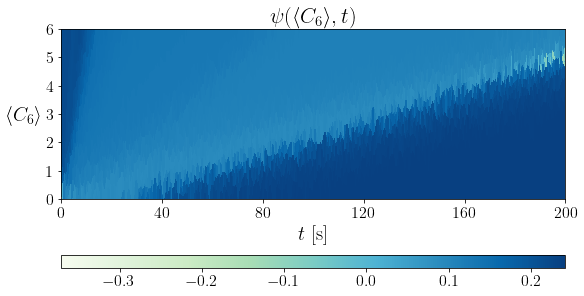

In [23]:
##optimal psi
X=grid_x
Y=grid_t
Z=grid_psi
fig, ax = plt.subplots(1, 1, constrained_layout=True) 
pcm=ax.imshow(Z,extent=[0, 200, 0, 6],cmap='GnBu', alpha=1)
plt.close()
fig, ax = plt.subplots(1, 1, constrained_layout=True) 
contours=ax.contourf(Y, X, Z, 1000, cmap='GnBu')
fig.colorbar(pcm, shrink=.9999, location='bottom')

plt.yticks(( 0, 1, 2,3,4,5,6))
plt.xticks((0, 40,80,120,160,200))
ax.set_title(r"$\psi(\langle C_{6} \rangle,t)$") 
ax.set_ylabel(r"$\langle C_{6} \rangle$", rotation="horizontal")
ax.set_xlabel(r" $t$ [s]", rotation="horizontal")
ax.yaxis.set_label_coords(-.07,.43)
fig.set_size_inches(8,4)
plt.savefig('ValueFunction.png', dpi=300)
grid_psi

In [24]:

#initial distribusion
def pdf1d_0(x):
    sigma = .2
    mu=0.
    a, b = (0. - mu) / sigma, (6. - mu) / sigma
    rho_0=truncnorm.pdf(x, a, b, loc = mu, scale = sigma)
    return rho_0

#Terminal distribusion
def pdf1d_T(x):
    mu = 5.
    sigma = .1
    a, b = (0. - mu) / sigma, (6. - mu) / sigma
    rho_T=truncnorm.pdf(x, a, b, loc = mu, scale = sigma)
    return rho_T




In [25]:
#optimally controlled joint PDFs

points = np.genfromtxt('points.out')
print(points.shape)

points_0=points[0,:]
points_02=points[1,:]
points_04=points[2,:]
points_06=points[3,:]
points_08=points[4,:]
end_points=points[5,:]



data_loaded = loadmat('data.mat')
new_list1=list(data_loaded.items())
con_arr1 = np.asarray(new_list1)

rho_0=np.asarray(con_arr1[1,1:])
rho_0=np.array(rho_0[0,]).reshape(-1,1)
# print(rho_0.shape)


rho_02=np.asarray(con_arr1[2,1:])
rho_02=np.array(rho_02[0,]).reshape(-1,1)
# print(rho_02.shape)


rho_04=np.asarray(con_arr1[3,1:])
rho_04=np.array(rho_04[0,]).reshape(-1,1)
# print(rho_04.shape)

rho_06=np.asarray(con_arr1[4,1:])
rho_06=np.array(rho_06[0,]).reshape(-1,1)
# print(rho_06.shape)


rho_08=np.asarray(con_arr1[5,1:])
rho_08=np.array(rho_08[0,]).reshape(-1,1)
# print(rho_08.shape)


rho_1=np.asarray(con_arr1[6,1:])
rho_1=np.array(rho_1[0,]).reshape(-1,1)
# print(rho_1.shape)


t_0=np.asarray(con_arr1[7,1:])
t_0=np.array(t_0[0,]).reshape(-1,1)
# print(t_0.shape)

t_02=np.asarray(con_arr1[8,1:])
t_02=np.array(t_02[0,]).reshape(-1,1)
# print(t_02.shape)


t_04=np.asarray(con_arr1[9,1:])
t_04=np.array(t_04[0,]).reshape(-1,1)
# print(t_04.shape)



t_06=np.asarray(con_arr1[10,1:])
t_06=np.array(t_06[0,]).reshape(-1,1)
# print(t_06.shape)


t_08=np.asarray(con_arr1[11,1:])
t_08=np.array(t_08[0,]).reshape(-1,1)
# print(t_08.shape)


t_1=np.asarray(con_arr1[12,1:])
t_1=np.array(t_1[0,]).reshape(-1,1)
# print(t_1.shape)


x_0=np.asarray(con_arr1[13,1:])
x_0=np.array(x_0[0,]).reshape(-1,1)
# print(x_0.shape)


x_02=np.asarray(con_arr1[14,1:])
x_02=np.array(x_02[0,]).reshape(-1,1)
# print(x_02.shape)



x_04=np.asarray(con_arr1[15,1:])
x_04=np.array(x_04[0,]).reshape(-1,1)
# print(x_04.shape)


x_06=np.asarray(con_arr1[16,1:])
x_06=np.array(x_06[0,]).reshape(-1,1)
# print(x_06.shape)


x_08=np.asarray(con_arr1[17,1:])
x_08=np.array(x_08[0,]).reshape(-1,1)
# print(x_08.shape)



x_1=np.asarray(con_arr1[18,1:])
x_1=np.array(x_1[0,]).reshape(-1,1)
# print(x_1.shape)







(6, 100)


<ipython-input-25-728217ac22e7>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  con_arr1 = np.asarray(new_list1)


No handles with labels found to put in legend.


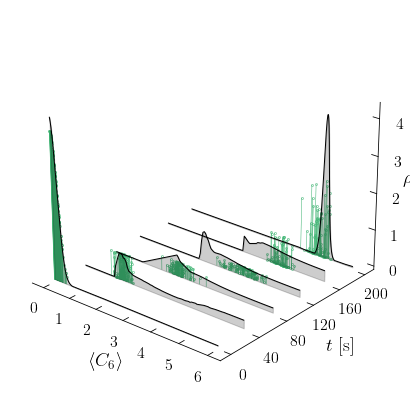

In [26]:
# plotting optimally controlled joint PDFs
T_0=0. 

plt.figure()
ax = plt.subplot(projection='3d')

x0=points_0
rho0=pdf1d_0(points_0).reshape(len(points_0),1)


points_0=points_0.reshape(len(points_0),1)
t0=T_0*np.ones(( 1,len(points_0))).reshape(len(points_0),1)

x0=points_0[:,0]
t0=t0[:,0]

data=x0
density = gaussian_kde(data)
xs = np.linspace(0,2,len(x0))
density.covariance_factor = lambda : 2
density._compute_covariance()

z0=rho0[:,0]




# plotting the stems
for i in range(len(x0)):
  ax.plot([x0[i], x0[i]], [t0[i], t0[i]], [0, z0[i]], linewidth=0.5, color='mediumseagreen')

# plotting a circle on the top of each stem
ax.plot(x0, t0, z0, 'o', markersize=2, 
        markerfacecolor='none', markeredgewidth=0.5, color='mediumseagreen')


##################################################################################################
T_0=40. 

x0=points_02
x0=x0.reshape(len(x0),1)
t0=T_0*np.ones(( 1,len(x0))).reshape(len(x0),1)

x0=x0[:,0]
t0=t0[:,0]

data=x0
density = gaussian_kde(data)
xs = np.linspace(0,2,len(x0))
density.covariance_factor = lambda :3
density._compute_covariance()
z0=density(xs)




# plotting the stems
for i in range(len(x0)):
  ax.plot([x0[i], x0[i]], [t0[i], t0[i]], [0, z0[i]], linewidth=0.5, color='mediumseagreen')

# plotting a circle on the top of each stem
ax.plot(x0, t0, z0, 'o', markersize=2, 
        markerfacecolor='none', markeredgewidth=0.5, color='mediumseagreen')



##################################################################################################
T_0=80.

x0=points_04

x0=x0.reshape(len(x0),1)
t0=T_0*np.ones(( 1,len(x0))).reshape(len(x0),1)

x0=x0[:,0]
t0=t0[:,0]

data=x0
density = gaussian_kde(data)
xs = np.linspace(0,4,len(x0))
density.covariance_factor = lambda : 4
density._compute_covariance()
z0=density(xs)




# plotting the stems
for i in range(len(x0)):
  ax.plot([x0[i], x0[i]], [t0[i], t0[i]], [0, z0[i]], linewidth=0.5, color='mediumseagreen')

# plotting a circle on the top of each stem
ax.plot(x0, t0, z0, 'o', markersize=2, 
        markerfacecolor='none', markeredgewidth=0.5, color='mediumseagreen')


##################################################################################################
T_0=120.

x0=points_06

x0=x0.reshape(len(x0),1)
t0=T_0*np.ones(( 1,len(x0))).reshape(len(x0),1)

x0=x0[:,0]
t0=t0[:,0]

data=x0
density = gaussian_kde(data)
xs = np.linspace(0,6,len(x0))
density.covariance_factor = lambda : 4
density._compute_covariance()
z0=density(xs)




# plotting the stems
for i in range(len(x0)):
  ax.plot([x0[i], x0[i]], [t0[i], t0[i]], [0, z0[i]], linewidth=0.5, color='mediumseagreen')

# plotting a circle on the top of each stem
ax.plot(x0, t0, z0, 'o', markersize=2, 
        markerfacecolor='none', markeredgewidth=0.5, color='mediumseagreen')





##################################################################################################
T_0=160.

x0=points_08

x0=x0.reshape(len(x0),1)
t0=T_0*np.ones(( 1,len(x0))).reshape(len(x0),1)

x0=x0[:,0]
t0=t0[:,0]

data=x0
density = gaussian_kde(data)
xs = np.linspace(1,6,len(x0))
density.covariance_factor = lambda : 2
density._compute_covariance()
z0=density(xs)


# plotting the stems
for i in range(len(x0)):
  ax.plot([x0[i], x0[i]], [t0[i], t0[i]], [0, z0[i]], linewidth=0.5, color='mediumseagreen')

# plotting a circle on the top of each stem
ax.plot(x0, t0, z0, 'o', markersize=2, 
        markerfacecolor='none', markeredgewidth=0.5, color='mediumseagreen')



##################################################################################################
T_1=200.

x1=end_points

x1=x1.reshape(len(x1),1)
t1=T_1*np.ones(( 1,len(x1))).reshape(len(x1),1)

x1=x1[:,0]
t1=t1[:,0]

data=x1
density = gaussian_kde(data)
xs = np.linspace(4,6,100)
density.covariance_factor = lambda : .1
density._compute_covariance()
z=density(xs)



# plotting the stems
for i in range(len(x0)):
  ax.plot([x1[i], x1[i]], [t1[i], t1[i]], [0, z[i]], linewidth=0.5, color='mediumseagreen')

# plotting a circle on the top of each stem
ax.plot(x1, t1, z, 'o', markersize=2, 
        markerfacecolor='none', markeredgewidth=0.5, color='mediumseagreen')


ax.plot(x_0[:,0], t_0[:,0] ,rho_0[:,0], color='k',lw=1)
ax.add_collection3d(plt.fill_between(x_0[:,0],rho_0[:,0],t_0[:,0],color='k',alpha=0.1),zdir='y')
ax.plot(x_02[:,0], t_02[:,0] ,rho_02[:,0], color='k',lw=1)
ax.add_collection3d(plt.fill_between(x_02[:,0],rho_02[:,0],-0.01,color='k',alpha=0.1),zs=40,zdir='y')
ax.plot(x_04[:,0], t_04[:,0] ,rho_04[:,0], color='k',lw=1)
ax.add_collection3d(plt.fill_between(x_04[:,0],rho_04[:,0],-0.01,color='k',alpha=0.1),zs=80,zdir='y')
ax.plot(x_06[:,0], t_06[:,0] ,rho_06[:,0], color='k',lw=1)
ax.add_collection3d(plt.fill_between(x_06[:,0],rho_06[:,0],-0.01,color='k',alpha=0.1),zs=120,zdir='y')
ax.plot(x_08[:,0], t_08[:,0] ,rho_08[:,0], color='k',lw=1)
ax.add_collection3d(plt.fill_between(x_08[:,0],rho_08[:,0],-0.01,color='k',alpha=0.1),zs=160,zdir='y')
ax.plot(x_1[:,0], t_1[:,0] ,rho_1[:,0], color='k',lw=1)
ax.add_collection3d(plt.fill_between(x_1[:,0],rho_1[:,0],-0.01,color='k',alpha=0.1),zs=200,zdir='y')

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.legend(markerscale=5, scatterpoints=3,frameon=False)
# Get rid of the panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# Get rid of the spines
# ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
# ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
# ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
# adjust view if needed
ax.view_init(elev=25, azim=-50)
# make ticks sexy
ax.xaxis._axinfo['tick']['inward_factor'] = 0
ax.xaxis._axinfo['tick']['outward_factor'] = 0.4
ax.yaxis._axinfo['tick']['inward_factor'] = 0
ax.yaxis._axinfo['tick']['outward_factor'] = 0.4
ax.zaxis._axinfo['tick']['inward_factor'] = 0
ax.zaxis._axinfo['tick']['outward_factor'] = 0.4

plt.xticks(( 0, 1, 2,3,4,5,6))
plt.yticks((0, 40,80,120,160,200))

# adjust the following as appropriate
ax.set_zticks([0,1,2,3,4])
ax.get_xaxis().set_tick_params(direction='in')
ax.get_yaxis().set_tick_params(direction='in')

# add texts if needed
ax.text(7,229, 2.3, r"$\rho^{\pi}_{\rm{opt}}$ ",size=19)
ax.text(8,70, -0.3, r" $t$ [s]",size=19)
ax.text(3.6,-80, -0.4, r"$\langle C_{6} \rangle$",size=19)


plt.savefig('OptimallyControlledJointPDFsFromPINNwithKDEstemFromClosedLoppEM.png', dpi=300)



findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


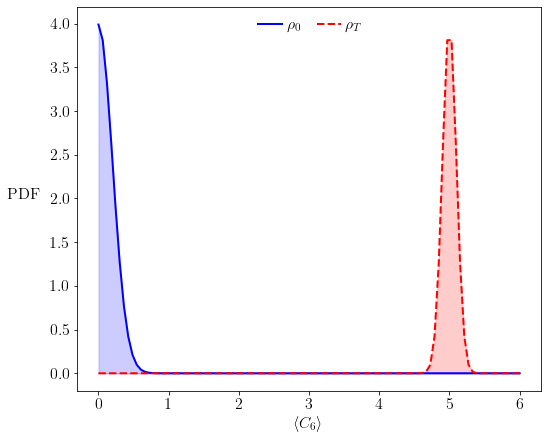

In [27]:
# InitialAndTerminalPDFs
x=np.linspace(0,6,100)
rho_0_p=pdf1d_0(x)
rho_1_p=pdf1d_T(x)

fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
ax.plot(x, rho_0_p, '-b', linewidth=2, label=r'$\rho_0$')
ax.plot(x, rho_1_p, '--r', linewidth=2, label=r'$\rho_1$')
labels=[r'$\rho_0$',r'$\rho_T$']
ax.text(-1.3,2, 'PDF',size=16)
ax.set_xlabel(r'$\langle C_{6} \rangle$', fontsize=16)
plt.legend(labels, ncol=2, loc='upper center', frameon=False, prop={'size':16}, bbox_to_anchor=[.5,.99], columnspacing=1.0, labelspacing=0.0, handletextpad=0.3, handlelength=1.5)


plt.fill_between(
        x= x, 
        y1= rho_0_p, 
        color= "b",
        alpha= 0.2)
        
plt.fill_between(
        x= x, 
        y1= rho_1_p, 
        color= "r",
        alpha= 0.2)
    
plt.savefig('InitialAndTerminalPDFs.png', dpi=300)





<ipython-input-28-516dda08d424>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  con_arr1 = np.asarray(new_list1)


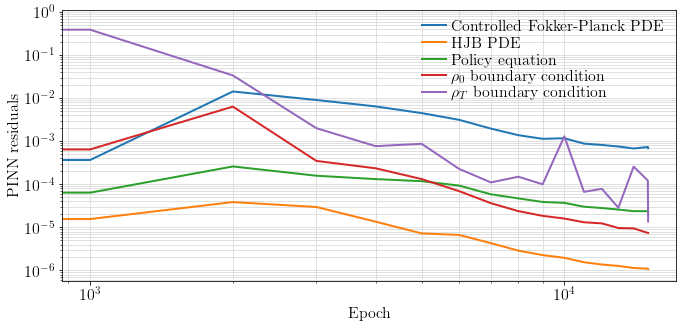

In [28]:
#PINN residual
loss_loaded = loadmat('loss.mat')
new_list1=list(loss_loaded.items())
con_arr1 = np.asarray(new_list1)
# print(con_arr1)
FPK_loss=np.asarray(con_arr1[0,1:])
FPK_loss=np.array(FPK_loss[0,]).reshape(-1,1)
# print(FPK_loss)

HJB_loss=np.asarray(con_arr1[1,1:])
HJB_loss=np.array(HJB_loss[0,]).reshape(-1,1)
# print(HJB_loss)

IC_loss=np.asarray(con_arr1[2,1:])
IC_loss=np.array(IC_loss[0,]).reshape(-1,1)
# print(IC_loss)

TC_loss=np.asarray(con_arr1[3,1:])
TC_loss=np.array(TC_loss[0,]).reshape(-1,1)
# print(TC_loss)

epoch=np.asarray(con_arr1[4,1:])
epoch=np.array(epoch[0,]).reshape(-1,1)
# print(epoch)


pi_loss=np.asarray(con_arr1[6,1:])
pi_loss=np.array(pi_loss[0,]).reshape(-1,1)
# print(pi_loss)




fig, ax = plt.subplots(1,1,sharex=True, sharey=True)

ax.loglog(epoch, FPK_loss, linewidth=2, label='Controlled Fokker-Planck PDE')
ax.loglog(epoch, HJB_loss, linewidth=2, label='HJB PDE')
ax.loglog(epoch, pi_loss, linewidth=2, label='policy equation')
ax.loglog(epoch, IC_loss, linewidth=2, label=r'$\rho_{0}$ boundary condition')
ax.loglog(epoch, TC_loss, linewidth=2, label=r'$\rho_{T}$ boundary condition')
labels=[r'$\rho_0$',r'$\rho_T$']
# ax.grid()
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel( "PINN residuals", fontsize=16,rotation="vertical")
labels=['Controlled Fokker-Planck PDE','HJB PDE','Policy equation',r'$\rho_{0}$ boundary condition',r'$\rho_{T}$ boundary condition']
plt.legend(labels, ncol=1,  prop={'size':16},frameon=False, bbox_to_anchor=[.99,.99], columnspacing=1.0, labelspacing=0.1, handletextpad=0.3, handlelength=1.5, shadow=True)
plt.grid(True, which="both", ls="-", color='.85')
fig.set_size_inches(11,5)

plt.savefig('PINN residuals.png', dpi=300)



